In [158]:
import os
import numpy as np
import pandas as pd
import re
from rouge_score import rouge_scorer
from typing import Optional
from sklearn.metrics import classification_report, accuracy_score

In [159]:
results_overview = dict()

In [160]:
root_path = os.path.dirname(os.path.dirname(os.getcwd()))

In [161]:
## INFERENCE LLAMA2 - 7B
# model_name = "llama-2-chat"
# model_size = "7B"
# model_display_name = "Llama-2 7B"
## base model
# job_id = "5817639"
## finetuned
# job_id = "5820349_finetuned"
## fintuned with balanced dataset
# job_id = "5836402_finetuned"
## inputs only
# job_id = "6090550_finetuned" ## (duplicate of 6153680)
# job_id = "6156654_finetuned" ## different hyperparams
# job_id = "6220572_finetuned"  ## (new, prompt with instructions)

## INFERENCE LLAMA2 - 13B
# model_name = "llama-2-chat"
# model_size = "13B"
# model_display_name = "Llama-2 13B"
## base model
# job_id = "5822467"
## finetuned
# job_id = "5830782_finetuned"

## INFERENCE CODELLAMA - PYTHON 7B
# model_name = "codellama-python"
# model_size = "7B"
# model_display_name = "CodeLlama-Python 7B"
## base model
# job_id = "5852469"
## finetuned
# job_id = "5897597_finetuned"

## INFERENCE CODELLAMA - PYTHON 13B
# model_name = "codellama-python"
# model_size = "13B"
# model_display_name = "CodeLlama-Python 13B"
## base model
# job_id = "5919626"
## finetuned
# job_id = "6127255_finetuned"
## finetuned with diff LR and batch size
# job_id = "6138639_finetuned"

## INFERENCE CODELLAMA - INSTRUCT 7B
# model_name = "codellama-instruct"
# model_size = "7B"
# model_display_name = "CodeLlama-Instruct 7B"
# # base model
# job_id = "5858736"
## finetuned
# job_id = "5892669_finetuned"
## inputs only
# job_id = "6153680_finetuned"  # incorrect prompt
# job_id = "6217554_finetuned"
# job_id = ""

## INFERENCE CODELLAMA - INSTRUCT 13B
# model_name = "codellama-instruct"
# model_size = "13B"
# model_display_name = "CodeLlama-Instruct 13B"
# # base model
# job_id = "5875184"
# finetuned
# job_id = "6001211_finetuned"

## INFERENCE LLAMA-3 8B
# model_name = "llama3"
# model_size = "8B"
# # base model
# job_id = "6013398"

results_path = os.path.join(root_path, "results_inference", model_name, model_size, job_id)

In [162]:
os.makedirs(os.path.join(results_path, "evaluation_new"), exist_ok=True)
try:
    test_set = pd.read_csv(os.path.join(results_path, "test.csv"))
except FileNotFoundError:
    test_set = pd.DataFrame()
    for i in [1, 2, 3, 4]:
        try:
            test_split = pd.read_csv(os.path.join(results_path, f"test_{i}.csv"))
            test_set = pd.concat([test_set, test_split], ignore_index=True)
        except FileNotFoundError:
            pass
    test_set.rename(columns={"inferred_script": "inferred_completion"}, inplace=True)
print(test_set.shape[0])
print(test_set.columns)

1736
Index(['sample_index', 'completion', 'prompt', 'source', 'input_prompt',
       'inferred_completion'],
      dtype='object')


In [163]:
test_set.rename(columns={"inferred_script": "inferred_completion"}, inplace=True)

In [164]:
test_set[test_set.duplicated(subset=["sample_index", "source"])].shape[0]

0

In [165]:
test_set.head()

,sample_index,completion,prompt,source,input_prompt,inferred_completion
0,386,```python\npicked_pears_keith = 47.0\npicked_p...,### Instruction:\n\nYou must write Python code...,awpnli,<s>[INST]\n<<SYS>>\nGive a response suitable t...,```python\npears_keith_picked_premise = 47.0\n...
1,140,```python\ninitial_students_premise = 10.0\nst...,### Instruction:\n\nYou must write Python code...,awpnli,<s>[INST]\n<<SYS>>\nGive a response suitable t...,\n```python\nnum_students_premise = 10.0\nnum_...
2,199,```python\nrows_premise = 27.0\nchairs_per_row...,### Instruction:\n\nYou must write Python code...,awpnli,<s>[INST]\n<<SYS>>\nGive a response suitable t...,```python\nrows_premise = 27.0\nchairs_per_row...
3,321,```python\nchildren_premise = 4.0\npencils_per...,### Instruction:\n\nYou must write Python code...,awpnli,<s>[INST]\n<<SYS>>\nGive a response suitable t...,\n```python\nnum_children_premise = 4.0\nnum_p...
4,633,```python\ncandy_premise = 3409.0\neggs_premis...,### Instruction:\n\nYou must write Python code...,awpnli,<s>[INST]\n<<SYS>>\nGive a response suitable t...,```python\npieces_candy_premise = 3409.0\nsecr...


In [166]:
def has_python_script(text: str) -> bool:
    """There is a complete or incomplete script in the LLM completion"""
    return (not pd.isna(text)) and ("```python" in text or "```" in text or "START_CODE" in text) and ("### Instruction" not in text and "### Output" not in text)

def has_non_python_script(completion: str):
    """CodeLlama gives Golang scripts, detect those by some common keywords"""
    return (not pd.isna(completion)) and ("package main" in completion or "Println" in completion or ":=" in completion)

def extract_script(text: str) -> Optional[str | None]:
    """Extract Python scripts from the completion"""
    if pd.isna(text):
        return np.nan
    if "START_CODE" in text:
        return extract_script_between_indicators(text, "START_CODE", "# END_CODE")
    elif "START_SECTION" in text and "```" not in text:
        return extract_script_between_indicators(text, "START_SECTION", "#END_SECTION")
    elif "write your code here" in text:
        return extract_script_with_write_code_here_indicator(text)
    elif "```python" in text:
        return extract_script_between_indicators(text, "```python\n```python", "\n```")
    else:
        script = extract_script_between_indicators(text, "```", "```")
        if script == np.nan:
            # sometimes the '''python part is missing
            script = text.rsplit("```", maxsplit=1)[0] + "\n"
            if script == "":
                script = text.split("```", maxsplit=1)[1].replace("python", "")
            if script.strip().strip("\n") == "":
                return np.nan
        return script
        # code_extraction_regex, code_extraction_regex_backup = r"```python([^`]+)```", r"```([^`]+)```"
        # scripts = re.findall(code_extraction_regex, text)
        # if not scripts:
        #     # rare case: max_tokens reached before "```" indicator is completely returned by LLM
        #     scripts = re.findall(code_extraction_regex_backup, text)
        #     if not scripts:
        #         script = None
        #         # sometimes the '''python part is missing
        #         if "```" in text:
        #             script = text.rsplit("```", maxsplit=1)[0]
        #             if script == "":
        #                 script = text.split("```", maxsplit=1)[1].replace("python", "")
        #         if script is None or script.strip().strip("\n") == "":
        #             return np.nan
        #         scripts = [script]

        # return scripts[0].replace("`", "").replace("python", "").lstrip("\n")


# def extract_script_with_start_code_indicators(text: str):
#     code_extraction_regex = r"START_CODE([^`]+)# END_CODE"
#     scripts = re.findall(code_extraction_regex, text)
#     if not scripts:
#         return np.nan
#     return scripts[0].replace("START_CODE", "").replace("# END_CODE", "").lstrip("\n")

def extract_script_with_write_code_here_indicator(text: str):
    return text.split("write your code here")[1].lstrip("\n")

# def extract_script_with_start_section_indicators(text: str):
#     code_extraction_regex = r"START_SECTION([^`]+)#END_SECTION"
#     scripts = re.findall(code_extraction_regex, text)
#     if not scripts:
#         return np.nan
#     script = scripts[0].replace("START_SECTION", "").replace("#END_SECTION", "").lstrip("\n")
#     if not script.endswith("\n"):
#         script += "\n"
#     return script

def extract_script_between_indicators(text: str, start_indicator: str, end_indicator: str):
    code_extraction_regex = fr"{start_indicator}([^`]+){end_indicator}"
    scripts = re.findall(code_extraction_regex, text)
    if not scripts:
        return np.nan
    script = scripts[0].replace(start_indicator, "").replace(end_indicator, "").lstrip("\n")
    if not script.endswith("\n"):
        script += "\n"
    return script

In [167]:
# script = """START_CODE
# some
# script here
# pam pam
# # END_CODE
# """

# extract_script_between_indicators(script, "```python", "```")
# extract_script_between_indicators(script, "```", "```")
# extract_script_between_indicators(script, "START_SECTION", "#END_SECTION")
# extract_script_between_indicators(script, "START_CODE", "# END_CODE")

### Any empty completions?

In [168]:
empty_completions = test_set[(test_set["inferred_completion"].isna()) | (test_set["inferred_completion"].isin(["", " "]))].shape[0]
results_overview["empty_completions"] = empty_completions
empty_completions

0

### How many completions with Python scripts?

In [169]:
test_set["has_script"] = test_set["inferred_completion"].apply(lambda completion: has_python_script(completion))

python_scripts = test_set[test_set["has_script"] == True].shape[0]
results_overview["python_scripts"] = python_scripts
python_scripts

1736

### How many completions with Golang scripts?

In [170]:
test_set["has_non_python_script"] = test_set["inferred_completion"].apply(lambda completion: has_non_python_script(completion))

non_python_scripts = test_set[test_set["has_non_python_script"] == True].shape[0]
results_overview["non_python_scripts"] = non_python_scripts
non_python_scripts

0

### Check there cannot be both Python and non-Python scripts in one completion

In [171]:
test_set[(test_set["has_script"]==True) & (test_set["has_non_python_script"]==True)].shape[0]

0

#### Per dataset, what is the split between generated (complete or not) scripts and missing scripts?

In [172]:
test_set.groupby(["source", "has_script"]).count()["sample_index"]

source      has_script
awpnli      True           179
newsnli     True           239
redditnli   True            61
rtequant    True            40
stresstest  True          1217
Name: sample_index, dtype: int64

#### Inspect some of the identified Python scripts

In [173]:
test_set["inferred_script"] = test_set["inferred_completion"].apply(lambda completion: extract_script(completion))

In [174]:
test_set["inferred_script"].iloc[0]

'pears_keith_picked_premise = 47.0\npears_mike_picked_premise = 12.0\npears_keith_gave_away_premise = 46.0\npears_mike_left_hypothesis = 13.0\n\n# the hypothesis refers to the number of pears left by Mike, which are also mentioned in the premise\n# compute the total number of pears picked by both Keith and Mike\ntotal_pears_picked_premise = pears_keith_picked_premise + pears_mike_picked_premise\n# compute the total number of pears given away by Keith\ntotal_pears_given_away_premise = pears_keith_gave_away_premise\n# compute the total number of pears left by Mike\ntotal_pears_left_premise = total_pears_picked_premise - total_pears_given_away_premise\nif total_pears_left_premise!= pears_mike_left_hypothesis:\n    # check if the number of pears left by Mike in the hypothesis contradicts the number of pears left from the premise\n    label = "contradiction"\nelse:\n    # if the hypothesis values and estimates do not contradict the premise values, we can infer entailment\n    label = "entai

### We notice that some scripts only return a boolean value, but there is no reasoning/math logic to infer it, so these scripts should be skipped during the evaluation

In [175]:
def returns_only_label(script: str):
    """Detect Python scripts that return directly a label, with no reasoning"""
    if pd.isna(script):
        return False
    script = script.replace("\n", "").strip()
    return script == "True" or script == "False"

In [176]:
test_set["only_label"] = test_set["inferred_script"].apply(lambda script: returns_only_label(script))
label_only = test_set[test_set["only_label"] == True].shape[0]
results_overview["label_only"] = label_only
label_only

0

#### For how many samples the `max_new_tokens` limit was exceeded before the full script could not be outputted?

In [177]:
def incomplete_script(has_script: bool, script: Optional[str | None]) -> bool:
    return has_script and pd.isna(script)

test_set["tokens_exceeded"] = test_set.apply(lambda row: incomplete_script(row["has_script"], row["inferred_script"]), axis=1)
tokens_exceeded = test_set[test_set["tokens_exceeded"]==True].shape[0]
results_overview["tokens_exceeded"] = tokens_exceeded
tokens_exceeded

2

In [178]:
test_set["expected_script"] = test_set["completion"].str.replace("```", "")
test_set["expected_script"] = test_set["expected_script"].str.replace("python", "").str.lstrip("\n")

### COMPUTE SIMILARITY BETWEEN TARGET AND INFERRED COMPLETION

In [179]:
# Your generated text and the reference text
generated_text = "The weather outside is so good today!"
reference_text = "Today we have such good weather outside!"

#### ROUGE metric

In [180]:
# Create a scorer object
scorer_1 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
scorer_2 = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)
scorer_L = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def rouge1_score(reference_text: str, generated_text: str, compute_score: bool):
    if not (pd.isna(reference_text) or pd.isna(generated_text)) and compute_score:
        return round(scorer_1.score(reference_text, generated_text)['rouge1'].fmeasure, 4)
    return np.nan

def rouge2_score(reference_text: str, generated_text: str, compute_score: bool):
    if not (pd.isna(reference_text) or pd.isna(generated_text)) and compute_score:
        return round(scorer_2.score(reference_text, generated_text)['rouge2'].fmeasure, 4)
    return np.nan

def rougeL_score(reference_text: str, generated_text: str, compute_score: bool):
    if not (pd.isna(reference_text) or pd.isna(generated_text)) and compute_score:
        return round(scorer_L.score(reference_text, generated_text)['rougeL'].fmeasure, 4)
    return np.nan

In [181]:
print(rouge1_score(reference_text, generated_text, True))
print(rouge2_score(reference_text, generated_text, True))
print(rougeL_score(reference_text, generated_text, True))

0.5714
0.1667
0.2857


#### METEOR metric

In [182]:
import nltk
from nltk.translate.meteor_score import single_meteor_score

# Ensure that NLTK's tokenizers and taggers are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

def meteor_score(reference_text: str, generated_text: str, compute_score: bool):
    if not (pd.isna(reference_text) or pd.isna(generated_text)) and compute_score:
        return round(single_meteor_score(reference_text.split(" "), generated_text.split(" ")), 4)
    return np.nan

print(meteor_score(reference_text, generated_text, True))

0.1429


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ioanamazilu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ioanamazilu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [183]:
# import nltk
# from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu
# from tree_sitter import Language, Parser
#
# # Load your programming language grammar, assuming Python here
# # Language.build_library(
# #   'build/my-languages.so',
# #   ['python']
# # )
# PY_LANGUAGE = Language('parser/my-languages.so', 'python')
# parser = Parser()
# parser.set_language(PY_LANGUAGE)
#
# def get_tokens(code):
#     """Extract tokens from source code using tree-sitter."""
#     tree = parser.parse(bytes(code, "utf8"))
#     root_node = tree.root_node
#     tokens = [node.text.decode('utf8') for node in root_node.walk() if node.type == 'identifier']
#     return tokens
#
# # Example codes
# generated_code = "def add(a, b):\n    return a + b"
# reference_code = ["def add(num1, num2):\n    return num1 + num2"]
#
# # Tokenize codes
# tokenized_generated_code = get_tokens(generated_code)
# tokenized_reference_code = [get_tokens(ref) for ref in reference_code]
#
# # Compute BLEU score
# chencherry = SmoothingFunction()
# bleu_score = corpus_bleu(tokenized_reference_code, [tokenized_generated_code], smoothing_function=chencherry.method1)
#
# print(f"CodeBLEU (simplified, BLEU part only) score: {bleu_score}")

#### CHRF score

In [184]:
import nltk
from nltk.translate.chrf_score import sentence_chrf

# Ensure that NLTK's tokenizers and data are available
nltk.download('punkt')

def chrf_score(reference_text: str, generated_text: str, compute_score: bool):
    if not (pd.isna(reference_text) or pd.isna(generated_text)) and compute_score:
        return round(sentence_chrf(reference_text, generated_text), 4)
    return np.nan

print(f"CHRF score: {chrf_score(reference_text, generated_text, True)}")

CHRF score: 0.4935


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ioanamazilu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Compare inferred and expected scripts only for valid Python scripts

In [185]:
def evaluate_script(row):
    """Evaluate a script only if it is a complete Python script that does not return a label directly """
    return not row["tokens_exceeded"] and not row["only_label"] and row["has_script"]

test_set["evaluate_script"] = test_set.apply(lambda row: evaluate_script(row), axis=1)
evaluated_scripts = test_set[test_set["evaluate_script"]==True].shape[0]
results_overview["evaluated_scripts"] = evaluated_scripts
evaluated_scripts

1734

In [186]:
test_set["rouge1_score"] = test_set.apply(lambda row: rouge1_score(row["expected_script"], row["inferred_script"], row["evaluate_script"]), axis=1)
test_set["rouge2_score"] = test_set.apply(lambda row: rouge2_score(row["expected_script"], row["inferred_script"], row["evaluate_script"]), axis=1)
test_set["rougeL_score"] = test_set.apply(lambda row: rougeL_score(row["expected_script"], row["inferred_script"], row["evaluate_script"]), axis=1)
test_set["meteor_score"] = test_set.apply(lambda row: meteor_score(row["expected_script"], row["inferred_script"], row["evaluate_script"]), axis=1)
test_set["chrf_score"] = test_set.apply(lambda row: chrf_score(row["expected_script"], row["inferred_script"], row["evaluate_script"]), axis=1)

In [187]:
score_columns = [col for col in test_set.columns if "_score" in col]
code_similarity_scores = test_set[score_columns].aggregate(["mean", "std"])

code_similarity_scores.T

,mean,std
rouge1_score,0.700233,0.162396
rouge2_score,0.512777,0.201682
rougeL_score,0.633561,0.179538
meteor_score,0.600381,0.208247
chrf_score,0.658754,0.167556


## Write the inferred scripts to python files for QNLI classification evaluation & code quality evaluation

In [188]:
test_set["evaluate_script"].value_counts()

evaluate_script
True     1734
False       2
Name: count, dtype: int64

In [189]:
dataset_name_mapping = {
    "stresstest": "StressTest",
    "rtequant": "RTE_Quant",
    "awpnli": "AWPNLI",
    "newsnli": "NewsNLI",
    "redditnli": "RedditNLI"
}

for _, dataset in dataset_name_mapping.items():
    os.makedirs(os.path.join(results_path, "scripts", dataset), exist_ok=True)

def write_script_to_file(sample_index: str, source_dataset: str, script: Optional[str | None], evaluate_script: bool):
    if not evaluate_script:
        return False
    try:
        with open(os.path.join(results_path, "scripts", dataset_name_mapping[source_dataset], f"sample_{sample_index}.py"), 'x') as f:
            f.write(script)
        return True
    except FileExistsError:
        with open(os.path.join(results_path, "scripts", dataset_name_mapping[source_dataset], f"sample_{sample_index}.py"), 'w') as f:
            f.write(script)
        return True

In [190]:
test_set["script_to_file"] = test_set.apply(lambda row: write_script_to_file(row["sample_index"], row["source"], row["inferred_script"], row["evaluate_script"]), axis=1)

In [191]:
test_set[test_set["script_to_file"] == True].shape[0]

1734

In [192]:
from src.utils import run_script
from src.code_quality_utils import validate_code_quality

count = 0
for idx, row in test_set.iterrows():
    print(idx)
    qualified_for_classification = getattr(row, "evaluate_script")
    if qualified_for_classification:
        count += 1
        sample_index, dataset_key = getattr(row, "sample_index"), getattr(row, "source")
        dataset = dataset_name_mapping[dataset_key]
        script_path = os.path.join(results_path, "scripts", dataset, f"sample_{sample_index}.py")
        label, error_message = run_script(script_path)
        test_set.loc[idx, "inferred_label"] = label
        test_set.loc[idx, "error_message"] = error_message

        code_quality_scores, code_quality_resolutions = validate_code_quality(script_path)
        for score_key, score in code_quality_scores.items():
            test_set.loc[idx, score_key] = score
        test_set.loc[idx, "cc_resolutions"] = "; ".join(code_quality_resolutions)

print(f"Evaluated {count} scripts.")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [193]:
labels_obtained = test_set[test_set["inferred_label"].isin(["entailment", "contradiction", "neutral"])].shape[0]
results_overview["labels_obtained"] = labels_obtained
labels_obtained

1667

In [194]:
code_quality_scores = ['readability', 'document_size', 'redundancy_check', 'function_size']

code_quality_scores = test_set[code_quality_scores].aggregate(["mean", "std"])
code_quality_scores.T

,mean,std
readability,98.884769,8.868615
document_size,58.703576,16.441079
redundancy_check,90.188576,3.368564
function_size,100.000000,0.000000


In [195]:
code_quality_df = pd.concat([code_quality_scores.T, code_similarity_scores.T])
code_quality_df.to_excel(os.path.join(results_path, "evaluation_new", "code_quality.xlsx"))
code_quality_df

,mean,std
readability,98.884769,8.868615
document_size,58.703576,16.441079
redundancy_check,90.188576,3.368564
function_size,100.000000,0.000000
rouge1_score,0.700233,0.162396
rouge2_score,0.512777,0.201682
rougeL_score,0.633561,0.179538
meteor_score,0.600381,0.208247
chrf_score,0.658754,0.167556


In [196]:
test_set[~test_set["readability"].isna()].shape[0]

1734

## View results overview

In [197]:
results_overview

{'empty_completions': 0,
 'python_scripts': 1736,
 'non_python_scripts': 0,
 'label_only': 0,
 'tokens_exceeded': 2,
 'evaluated_scripts': 1734,
 'labels_obtained': 1667}

## QNLI results evaluation

In [198]:
# dataset_name_mapping = {
#     "stresstest": "StressTest",
#     "rtequant": "RTE_Quant",
#     "awpnli": "AWPNLI",
#     "newsnli": "NewsNLI",
#     "redditnli": "RedditNLI"
# }
#
# merged = pd.DataFrame()
# for dataset_key, dataset in dataset_name_mapping.items():
#     print(dataset)
#     df = pd.read_csv(os.path.join(root_path, "data", "equate_labelled", "processed", f"{dataset}.csv"))
#     print(f"All samples: {df.shape[0]}")
#     df["source"] = dataset_key
#     test_indices = test_set[test_set["source"]==dataset_key]["sample_index"].unique()
#     print(f"Test samples: {len(test_indices)}")
#     test_subset = df[df["sample_index"].isin(test_indices)]
#     if merged.shape[0] == 0:
#         merged = test_subset
#     else:
#         merged = pd.concat([merged, test_subset], ignore_index=True)
#
# merged.shape

In [199]:
# merged.columns

In [200]:
# merged.to_csv(os.path.join(root_path, "data", "finetuning", "test_all_with_labels.csv"), index=False)

In [201]:
gt_data = pd.read_csv(os.path.join(root_path, "data", "finetuning", "test_all_with_labels.csv"))
gt_data.shape

(1736, 6)

In [202]:
gt_data["source"].value_counts()

source
stresstest    1217
newsnli        239
awpnli         179
redditnli       61
rtequant        40
Name: count, dtype: int64

In [203]:
gt_data["golden_label"].value_counts(normalize=True)

golden_label
entailment       0.370392
contradiction    0.323157
neutral          0.306452
Name: proportion, dtype: float64

In [204]:
gt_data.groupby('source')["golden_label"].value_counts(normalize=True).reset_index().sort_values(by=["source", "golden_label"])

,source,golden_label,proportion
0,awpnli,contradiction,0.502793
1,awpnli,entailment,0.497207
2,newsnli,entailment,0.502092
3,newsnli,neutral,0.497908
6,redditnli,contradiction,0.081967
4,redditnli,entailment,0.573770
5,redditnli,neutral,0.344262
8,rtequant,entailment,0.425000
7,rtequant,neutral,0.575000
9,stresstest,contradiction,0.382909


In [205]:
0.370392**2+0.323157**2+0.306452**2

0.335533508617

In [206]:
qnli_results_df = pd.merge(test_set, gt_data, on=["sample_index", "source"], how="inner")
qnli_results_df.shape[0]

1736

In [207]:
qnli_results_df.columns

Index(['sample_index', 'completion', 'prompt', 'source', 'input_prompt',
       'inferred_completion', 'has_script', 'has_non_python_script',
       'inferred_script', 'only_label', 'tokens_exceeded', 'expected_script',
       'evaluate_script', 'rouge1_score', 'rouge2_score', 'rougeL_score',
       'meteor_score', 'chrf_score', 'script_to_file', 'inferred_label',
       'error_message', 'readability', 'document_size', 'redundancy_check',
       'function_size', 'cc_resolutions', 'premise', 'hypothesis',
       'golden_label', 'reference_label'],
      dtype='object')

In [208]:
qnli_results_df.drop("cc_resolutions", axis="columns", inplace=True)
# qnli_results_df.to_excel(os.path.join(results_path, "evaluation", "qnli_classification_results.xlsx"), index=False)

In [209]:
qnli_results_df["inferred_label"].value_counts()

inferred_label
contradiction    794
neutral          496
entailment       377
error             67
nan                2
Name: count, dtype: int64

In [210]:
dataset_name_mapping = {
    "stresstest": "StressTest",
    "rtequant": "RTE_Quant",
    "awpnli": "AWPNLI",
    "newsnli": "NewsNLI",
    "redditnli": "RedditNLI",
    "equate": "EQUATE"
}

In [211]:
def print_accuracies(results_df):
    """Get the accuracy of the model (base or fine-tuned) and GPT4 on each dataset and on EQUATE."""

    dataset_names, accuracies = [], []
    for dataset_key, dataset in dataset_name_mapping.items():
        # print(f"#################{dataset}#################")

        dataset_names.append(dataset)

        if dataset != "EQUATE":
            filtered_df = results_df[results_df["source"] == dataset_key]
        else:
            filtered_df = results_df

        acc = accuracy_score(filtered_df['golden_label'], filtered_df['inferred_label'])
        # print(f"Accuracy (model): {acc}")
        accuracies.append(acc)

        # print(f"Accuracy (GPT4): {accuracy_score(filtered_df['golden_label'], filtered_df['reference_label'])}")

    return pd.DataFrame({"dataset": dataset_names, "accuracy": accuracies})

In [212]:
def classification_report_to_dataframe(clsf_report, dataset):
    f1_score = pd.DataFrame(clsf_report)
    f1_score = f1_score.loc["f1-score"]

    for label in ["entailment", "contradiction", "neutral"]:
        if label not in f1_score.index:
            f1_score.loc[label] = 0

    f1_score = f1_score.loc[["entailment", "contradiction", "neutral", "weighted avg"]]
    f1_score_df = pd.DataFrame(dict(zip(["F1-E", "F1-C", "F1-N", "weighted_F1"], f1_score.values)), index=[1])
    f1_score_df["dataset"] = dataset

    return f1_score_df


def print_classification_reports(results_df):
    """Get the accuracy of the model (base or fine-tuned) and GPT4 on each dataset and on EQUATE."""

    clsf_report_dataset = pd.DataFrame()
    gpt4_report = pd.DataFrame()
    for dataset_key, dataset in dataset_name_mapping.items():
        # print(f"#################{dataset}#################")

        if dataset != "EQUATE":
            filtered_df = results_df[results_df["source"] == dataset_key]
        else:
            filtered_df = results_df

        # print("######Base / Fine-tuned model######")
        clsf_report_dict = classification_report(filtered_df['golden_label'], filtered_df['inferred_label'], output_dict=True)
        clsf_report_df = classification_report_to_dataframe(clsf_report_dict, dataset)
        clsf_report_dataset = pd.concat([clsf_report_dataset, clsf_report_df], ignore_index=True)
        # print(classification_report(filtered_df['golden_label'], filtered_df['inferred_label']))

        # print("######GPT4######")
        clsf_report_dict = classification_report(filtered_df['golden_label'], filtered_df['reference_label'], output_dict=True)
        clsf_report_df = classification_report_to_dataframe(clsf_report_dict, dataset)
        gpt4_report = pd.concat([gpt4_report, clsf_report_df], ignore_index=True)
        # print(classification_report(filtered_df['golden_label'], filtered_df['reference_label']))

    return clsf_report_dataset, gpt4_report

### For RTE_Quant and NewsNLI, convert "contradiction" to "neutral".

In [213]:
qnli_results_df[(qnli_results_df["inferred_label"] == "contradiction") & (qnli_results_df["source"].isin(["rtequant", "newsnli"]))].shape[0]

25

In [214]:
# Creating masks based on conditions
convert_contradiction_to_neutral_mask = qnli_results_df["inferred_label"] == "contradiction"
filter_dataset_mask = qnli_results_df["source"].isin(["rtequant", "newsnli"])

# Combining both masks
combined_mask = convert_contradiction_to_neutral_mask & filter_dataset_mask

# Correctly assigning a new value using the combined mask with .loc
qnli_results_df.loc[combined_mask, "inferred_label"] = "neutral"

Check that the conversion worked

In [215]:
qnli_results_df[(qnli_results_df["inferred_label"] == "contradiction") & (qnli_results_df["source"].isin(["rtequant", "newsnli"]))].shape[0]

0

In [216]:
qnli_results_df.to_excel(os.path.join(results_path, "evaluation_new", "qnli_classification_results.xlsx"), index=False)

### EVALUATION 1:  Impute majority label for each dataset where label is NaN or error.

#### First check how many labels we got for each dataset and for equate as a whole

In [217]:
test_samples_per_dataset = qnli_results_df["source"].value_counts().reset_index().sort_values(by="source").rename(columns={"count": "total"})

In [218]:
test_samples_per_dataset

,source,total
2,awpnli,179
1,newsnli,239
3,redditnli,61
4,rtequant,40
0,stresstest,1217


In [219]:
labels_obtained_df = qnli_results_df[qnli_results_df["inferred_label"].isin(["entailment", "neutral", "contradiction"])]
print(labels_obtained_df.shape[0])
obtained_labels_counts = labels_obtained_df["source"].value_counts().reset_index().sort_values(by="source")
obtained_labels_counts

1667


,source,count
2,awpnli,153
1,newsnli,236
3,redditnli,61
4,rtequant,37
0,stresstest,1180


In [220]:
obtained_labels = pd.merge(test_samples_per_dataset, obtained_labels_counts, on="source")
obtained_labels

,source,total,count
0,awpnli,179,153
1,newsnli,239,236
2,redditnli,61,61
3,rtequant,40,37
4,stresstest,1217,1180


In [221]:
obtained_labels["ratio"] = round(obtained_labels["count"] / obtained_labels["total"], 4)
obtained_labels

,source,total,count,ratio
0,awpnli,179,153,0.8547
1,newsnli,239,236,0.9874
2,redditnli,61,61,1.0000
3,rtequant,40,37,0.9250
4,stresstest,1217,1180,0.9696


In [222]:
obtained_labels[["source", "count", "ratio"]].to_excel(os.path.join(results_path, "evaluation_new", "counts_and_ratios_obtained_labels.xlsx"), index=False)

In [223]:
# for dataset, majority_label in zip(["rtequant", "redditnli", "newsnli", "awpnli", "stresstest"], ["neutral", "entailment", "entailment", "contradiction", "contradiction"]):
#     mask_label = ~qnli_results_df["inferred_label"].isin(["entailment", "neutral", "contradiction"])
#     mask_source = qnli_results_df["source"] == dataset
#     qnli_results_df.loc[mask_label & mask_source, "inferred_label"] = majority_label
# qnli_results_df["inferred_label"].value_counts()

In [224]:
# accuracy_df = print_accuracies(qnli_results_df)

In [225]:
# f1_df, gpt_f1 = print_classification_reports(qnli_results_df)

In [226]:
# evaluation_df = pd.merge(accuracy_df, f1_df, on="dataset", how="inner")
# evaluation_df

In [227]:
# # gpt_f1.to_excel("gpt4_f1_evaluation.xlsx", index=False)

In [228]:
# evaluation_df.to_excel(os.path.join(results_path, "evaluation", "imputed_mb_label.xlsx"), index=False)

### EVALUATION 2:  Drop samples with NaN script or "error"

In [229]:
# qnli_results_df = pd.merge(test_set, gt_data, on=["sample_index", "source"], how="inner")
# qnli_results_df.shape[0]

In [230]:
# # Creating masks based on conditions
# convert_contradiction_to_neutral_mask = qnli_results_df["inferred_label"] == "contradiction"
# filter_dataset_mask = qnli_results_df["source"].isin(["rtequant", "newsnli"])
#
# # Combining both masks
# combined_mask = convert_contradiction_to_neutral_mask & filter_dataset_mask
#
# # Correctly assigning a new value using the combined mask with .loc
# qnli_results_df.loc[combined_mask, "inferred_label"] = "neutral"

In [231]:
# mask_discard = ~qnli_results_df["inferred_label"].isin(["entailment", "contradiction", "neutral"])
# qnli_results_df = qnli_results_df.drop(qnli_results_df[mask_discard].index, axis="rows")
# qnli_results_df["inferred_label"].value_counts()

In [232]:
# accuracy_df = print_accuracies(qnli_results_df)

In [233]:
# f1_df, gpt_f1 = print_classification_reports(qnli_results_df)

In [234]:
# evaluation_df = pd.merge(accuracy_df, f1_df, on="dataset", how="inner")
# evaluation_df

In [235]:
# evaluation_df.to_excel(os.path.join(results_path, "evaluation", "discard_erroneous_samples.xlsx"), index=False)

### EVALUATION 3: Impute the missing labels with a stratified random strategy

In [236]:
## INFERENCE LLAMA2 - 7B
# model_name = "llama-2-chat"
# model_size = "7B"
## base model
# job_id = "5817639"
## finetuned
# job_id = "5820349_finetuned"
## fintuned with balanced dataset
# job_id = "5836402_finetuned"

## INFERENCE LLAMA2 - 13B
# model_name = "llama-2-chat"
# model_size = "13B"
## base model
# job_id = "5822467"
## finetuned
# job_id = "5830782_finetuned"

## INFERENCE CODELLAMA - PYTHON 7B
# model_name = "codellama-python"
# model_size = "7B"
## base model
# job_id = "5852469"
## finetuned
# job_id = "5897597_finetuned"


##### REDO MATRI FOR AWPNLI ABOVE THIS

## INFERENCE CODELLAMA - PYTHON 13B
# model_name = "codellama-python"
# model_size = "13B"
## base model
# job_id = "5919626"
## finetuned
# job_id = ""

## INFERENCE CODELLAMA - INSTRUCT 7B
# model_name = "codellama-instruct"
# model_size = "7B"
# # base model
# job_id = "5858736"
## finetuned
# job_id = "5892669_finetuned"

## INFERENCE CODELLAMA - INSTRUCT 13B
# model_name = "codellama-instruct"
# model_size = "13B"
# # base model
# job_id = "5875184"
# finetuned
# job_id = "6001211_finetuned"

## INFERENCE LLAMA-3 8B
# model_name = "llama3"
# model_size = "8B"
# # base model
# job_id = "6013398"

# results_path = os.path.join(root_path, "results_inference", model_name, model_size, job_id)

In [237]:
# ## CONFUSION MATRICES FOR GPT4
#
# qnli_results_df = pd.read_excel(os.path.join(results_path, "evaluation", "qnli_classification_results.xlsx"))
#
# # for dataset in ["rtequant", "newsnli", "awpnli", "stresstest", "redditnli"]:  #
# #     filtered_df = qnli_results_df[qnli_results_df["source"] == dataset]
# #     if dataset in ["rtequant", "newsnli"]:
# #         labels = ["entailment", "neutral"]
# #     elif dataset == "awpnli":
# #         labels = ["contradiction", "entailment"]
# #     else:
# #         labels = ["contradiction", "entailment", "neutral"]
# #     cf = confusion_matrix(filtered_df["golden_label"], filtered_df["reference_label"], labels=labels, normalize="true")
# #     display = ConfusionMatrixDisplay(cf, display_labels=labels)
# #     display.plot(cmap=custom_cmap)
# #     plt.title(f"GPT4 - {dataset_name_mapping[dataset]}")
# #     # Increase font size of the numbers within the squares
# #     for text in display.text_.ravel():
# #         text.set_fontsize(24)  # Adjust font size as needed
# #     plt.savefig(os.path.join(root_path, "results_inference", "gpt4", f"{dataset}_confusion_matrix.pdf"))
#
# cf = confusion_matrix(qnli_results_df["golden_label"], qnli_results_df["reference_label"], labels = ["contradiction", "entailment", "neutral"], normalize="true")
# display = ConfusionMatrixDisplay(cf, display_labels=["C", "E", "N"])
# display.plot(cmap=custom_cmap)
# # Increase font size of the numbers within the squares
# for text in display.text_.ravel():
#     text.set_fontsize(24)  # Adjust font size as needed
# # Increase label size
# plt.gca().tick_params(axis='both', which='major', labelsize=20)
# plt.title("GPT4 - EQUATE")
# # Increase font size of the axis labels
# plt.xlabel('Predicted label', fontsize=16)  # X-axis label
# plt.ylabel('True label', fontsize=16)       # Y-axis label
# # plt.savefig(os.path.join(root_path, "results_inference", "gpt4", f"EQUATE_confusion_matrix_test.pdf"))

In [238]:
# qnli_results_df = pd.merge(test_set, gt_data, on=["sample_index", "source"], how="inner")
# qnli_results_df.shape[0]

In [239]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap
#
# # Define custom colormap from white to black
# cmap_colors = [(0, 0, 0), (1, 1, 1)]  # White to Black
# custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
#
# qnli_results_df = pd.read_excel(os.path.join(results_path, "evaluation", "qnli_classification_results.xlsx"))
# filtered_results = qnli_results_df[qnli_results_df["inferred_label"].isin(["entailment", "contradiction", "neutral"])]
#
# for dataset in ["awpnli", "stresstest", "redditnli", "rtequant", "newsnli",]:
#     filtered_df = filtered_results[filtered_results["source"] == dataset]
#     if dataset in ["rtequant", "newsnli"]:
#         labels = ["entailment", "neutral"]
#     elif dataset == "awpnli":
#         labels = ["contradiction", "entailment"]
#     else:
#         labels = ["contradiction", "entailment", "neutral"]
#     cf = confusion_matrix(filtered_df["golden_label"], filtered_df["inferred_label"], labels=labels, normalize="true")
#     display = ConfusionMatrixDisplay(cf, display_labels=labels)
#     # Increase label size within the squares
#     display.plot(cmap=custom_cmap)
#     # Increase font size of the numbers within the squares
#     for text in display.text_.ravel():
#         text.set_fontsize(24)  # Adjust font size as needed
#     plt.title(f"CodeLlama-Instruct 13B - {dataset_name_mapping[dataset]}")
#     plt.savefig(os.path.join(results_path, f"{dataset}_confusion_matrix.pdf"))
#
# cf = confusion_matrix(filtered_results["golden_label"], filtered_results["inferred_label"], labels = ["contradiction", "entailment", "neutral"], normalize="true")
# display = ConfusionMatrixDisplay(cf, display_labels=["contradiction", "entailment", "neutral"])
# display.plot(cmap=custom_cmap)
# # Increase font size of the numbers within the squares
# for text in display.text_.ravel():
#     text.set_fontsize(24)  # Adjust font size as needed
# plt.title("CodeLlama-Instruct 13B - EQUATE")
# plt.savefig(os.path.join(results_path, f"EQUATE_confusion_matrix.pdf"))

In [240]:
# def impute_rsb(df):
#     for dataset in ["rtequant", "redditnli", "newsnli", "awpnli", "stresstest"]:
#         mask_label = ~df["inferred_label"].isin(["entailment", "neutral", "contradiction"])
#         mask_source = df["source"] == dataset
#         nan_indices_len = df.loc[mask_label & mask_source].shape[0]
#         label_counts = df[df["source"]==dataset]["golden_label"].value_counts(normalize=True)
#         imputed_labels = np.random.choice(label_counts.index, size=nan_indices_len, p=label_counts.values)
#         df.loc[mask_label & mask_source, "inferred_label"] = imputed_labels
#     return df

In [241]:
# accuracies, f1_scores = pd.DataFrame(), pd.DataFrame()
# for rep in range(100):
#     qnli_results_df = pd.read_excel(os.path.join(results_path, "evaluation", "qnli_classification_results.xlsx"))
#     imputed_df = impute_rsb(qnli_results_df)
#     accuracies = pd.concat([accuracies, print_accuracies(imputed_df)], ignore_index=True)
#     f1_scores_df, _ = print_classification_reports(imputed_df)
#     f1_scores = pd.concat([f1_scores, f1_scores_df], ignore_index=True)
#
# avg_accuracy_df = accuracies.groupby("dataset")["accuracy"].aggregate(["mean", "std"]).reset_index().rename(columns={"mean": "acc_mean", "std": "acc_std"})
# avg_f1_df = f1_scores.groupby("dataset").aggregate(["mean", "std"])
# avg_f1_df.columns = [' '.join(col).strip() for col in avg_f1_df.columns.values]
# avg_f1_df.reset_index(inplace=True)
# evaluation_df = pd.merge(avg_accuracy_df, avg_f1_df, on="dataset", how="inner")

In [242]:
# evaluation_df

In [243]:
# accuracy_df = print_accuracies(qnli_results_df)

In [244]:
# f1_df, gpt_f1 = print_classification_reports(qnli_results_df)

In [245]:
# evaluation_df = pd.merge(accuracy_df, f1_df, on="dataset", how="inner")
# evaluation_df

In [246]:
# evaluation_df.to_excel(os.path.join(results_path, "evaluation", "srb_imputed.xlsx"), index=False)

In [247]:
# gpt_f1

In [248]:
# list(map(lambda f1: round(f1*100, 2), gpt_f1["micro_F1"].values))

### Perform some automatic quality tests on the scripts

In [249]:
# dataset_function_name_map = {
#     "stresstest": "entailment_or_contradiction_or_neutral(",
#     "redditnli": "entailment_or_contradiction_or_neutral(",
#     "awpnli": "entailment_or_contradiction(",
#     "newsnli": "entailment_or_neutral(",
#     "rtequant": "entailment_or_neutral("
# }
#
# def correct_function_name(script: str, dataset: str):
#     return (not pd.isna(script)) and dataset_function_name_map[dataset] in script
#
# test_set["correct_function_name"] = test_set.apply(lambda row: correct_function_name(row["inferred_script"], row["source"]), axis=1)
#
# scripts_with_correct_function_name = test_set[test_set["correct_function_name"]==True].shape[0]
# results_overview["correct_function_name"] = scripts_with_correct_function_name
# scripts_with_correct_function_name

In [250]:
# def script_length_in_lines(script: str):
#     if pd.isna(script):
#         return 0
#     return len(script.split("\n"))
#
# test_set["expected_script_length"] = test_set["expected_script"].apply(lambda script: script_length_in_lines(script))
# test_set["inferred_script_length"] = test_set["inferred_script"].apply(lambda script: script_length_in_lines(script))
#
# test_set[test_set["expected_script_length"] == test_set["inferred_script_length"]].shape[0]

In [251]:
# test_set[test_set["expected_script_length"] != test_set["inferred_script_length"]].head(5)

In [252]:
# results = dict()

In [253]:
# qnli_results_df = pd.read_excel(os.path.join(results_path, "evaluation", "qnli_classification_results.xlsx"))

In [254]:
# results["tokens_exceeded"] = qnli_results_df[qnli_results_df["tokens_exceeded"]].shape[0]
# results["missing_script"] = qnli_results_df[qnli_results_df["has_script"]==False].shape[0]
# # results["invalid_script"] = qnli_results_df[qnli_results_df[""]==True].shape[0]
# results["evaluated_scripts"] = qnli_results_df[qnli_results_df["evaluate_script"]==True].shape[0]
# results["labels_obtained"] = qnli_results_df[qnli_results_df["inferred_label"].isin(["entailment", "neutral", "contradiction"])].shape[0]

In [255]:
# results

In [256]:
# qnli_results_df.columns

In [257]:
# qnli_results_df[qnli_results_df["has_script"]==False]["inferred_completion"].head(5)

### Compute the baseline micro-F1 score for each sub-dataset and for EQUATE

In [258]:
# print(qnli_results_df[qnli_results_df["source"]=="awpnli"]["golden_label"].value_counts())
# print(qnli_results_df[qnli_results_df["source"]=="redditnli"]["golden_label"].value_counts())
# print(qnli_results_df[qnli_results_df["source"]=="newsnli"]["golden_label"].value_counts())
# print(qnli_results_df[qnli_results_df["source"]=="stresstest"]["golden_label"].value_counts())
# print(qnli_results_df[qnli_results_df["source"]=="rtequant"]["golden_label"].value_counts())
# print(qnli_results_df["golden_label"].value_counts())

In [259]:
# def weighted_avg_f1(f1_scores, num_samples_per_class):
#     total_samples = sum(num_samples_per_class)
#     weighted_sum = 0.0
#     total_weight = 0.0
#
#     for f1, num_samples in zip(f1_scores, num_samples_per_class):
#         weight = num_samples / total_samples
#         weighted_sum += f1 * weight
#         total_weight += weight
#
#     return round(weighted_sum * 100 / total_weight, 2)
#
# # E, C, N
# # awpnli
# print(weighted_avg_f1([0.4972, 0.5028], [89, 80]))
# # redditnli
# print(weighted_avg_f1([0.5738, 0.0819, 0.3443], [35, 5, 21]))
# # newsnli
# print(weighted_avg_f1([0.5021, 0.4979], [120, 119]))
# # stresstest
# print(weighted_avg_f1([0.3139, 0.3829, 0.3032], [382, 466, 369]))
# # rtequant
# print(weighted_avg_f1([0.4250, 0.5750], [17, 23]))
# # equate
# print(weighted_avg_f1([0.3704, 0.3232, 0.3064], [643, 561, 532]))

## EVALUATION 4 - consider missing labels as the wrong label

In [260]:
## INFERENCE LLAMA2 - 7B
# model_name = "llama-2-chat"
# model_display_name = "Llama-2 7B"
# model_size = "7B"
## base model
# job_id = "5817639"
## finetuned
# job_id = "5820349_finetuned"
## fintuned with balanced dataset
# job_id = "5836402_finetuned"

## INFERENCE LLAMA2 - 13B
# model_name = "llama-2-chat"
# model_display_name = "Llama-2 13B"
# model_size = "13B"
## base model
# job_id = "5822467"
## finetuned
# job_id = "5830782_finetuned"

## INFERENCE CODELLAMA - PYTHON 7B
# model_name = "codellama-python"
# model_display_name = "CodeLlama-Python 7B"
# model_size = "7B"
## base model
# job_id = "5852469"
## finetuned
# job_id = "5897597_finetuned"


##### REDO MATRI FOR AWPNLI ABOVE THIS

## INFERENCE CODELLAMA - PYTHON 13B
# model_name = "codellama-python"
# model_display_name = "CodeLlama-Python 13B"
# model_size = "13B"
## base model
# job_id = "5919626"
## finetuned
# job_id = ""

## INFERENCE CODELLAMA - INSTRUCT 7B
# model_name = "codellama-instruct"
# model_display_name = "CodeLlama-Instruct 7B"
# model_size = "7B"
# # base model
# job_id = "5858736"
## finetuned
# job_id = "5892669_finetuned"

## INFERENCE CODELLAMA - INSTRUCT 13B
# model_name = "codellama-instruct"
# model_display_name = "CodeLlama-Instruct 13B"
# model_size = "13B"
# # base model
# job_id = "5875184"
# finetuned
# job_id = "6001211_finetuned"

## INFERENCE LLAMA-3 8B
# model_name = "llama3"
# model_size = "8B"
# # base model
# job_id = "6013398"

results_path = os.path.join(root_path, "results_inference", model_name, model_size, job_id)

In [261]:
qnli_results_df = pd.read_excel(os.path.join(results_path, "evaluation_new", "qnli_classification_results.xlsx"))

In [262]:
missing_label_mask = ~qnli_results_df["inferred_label"].isin(["contradiction", "entailment", "neutral"])
qnli_results_df.loc[missing_label_mask, "inferred_label"] = "unknown"

In [263]:
qnli_results_df["golden_label"].value_counts()

golden_label
entailment       643
contradiction    561
neutral          532
Name: count, dtype: int64

In [264]:
qnli_results_df["golden_label"].value_counts(normalize=True)

golden_label
entailment       0.370392
contradiction    0.323157
neutral          0.306452
Name: proportion, dtype: float64

In [265]:
qnli_results_df["inferred_label"].value_counts()

inferred_label
contradiction    769
neutral          521
entailment       377
unknown           69
Name: count, dtype: int64

In [266]:
qnli_results_df["inferred_label"].value_counts(normalize=True)

inferred_label
contradiction    0.442972
neutral          0.300115
entailment       0.217166
unknown          0.039747
Name: proportion, dtype: float64

In [267]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_micro_scores(y_true, y_pred):
    micro_precision = precision_score(y_true, y_pred, average='micro')
    micro_recall = recall_score(y_true, y_pred, average='micro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    return round(micro_precision, 4), round(micro_recall, 4), round(micro_f1, 4)

    # precision = precision_score(y_true, y_pred, average="weighted")
    # recall = recall_score(y_true, y_pred, average="weighted")
    # f1 = f1_score(y_true, y_pred, average="weighted")
    # return round(precision, 4), round(recall, 4), round(f1, 4)

In [268]:
accuracy_df = print_accuracies(qnli_results_df)

In [269]:
f1_df, gpt_f1 = print_classification_reports(qnli_results_df)

/Users/ioanamazilu/PycharmProjects/quant_nli/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ioanamazilu/PycharmProjects/quant_nli/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ioanamazilu/PycharmProjects/quant_nli/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [270]:
evaluation_df = pd.merge(accuracy_df, f1_df, on="dataset", how="inner")

In [271]:
evaluation_df

,dataset,accuracy,F1-E,F1-C,F1-N,weighted_F1
0,StressTest,0.384552,0.146912,0.514134,0.399399,0.364080
1,RTE_Quant,0.625000,0.631579,0.000000,0.666667,0.651754
2,AWPNLI,0.715084,0.729730,0.804348,0.000000,0.767247
3,NewsNLI,0.523013,0.325301,0.000000,0.634304,0.479156
4,RedditNLI,0.622951,0.753623,0.428571,0.461538,0.626426
5,EQUATE,0.451613,0.319608,0.553383,0.480532,0.444469


In [272]:
# rows = []
# for dataset in list(qnli_results_df["source"].unique()):
#     filtered_df = qnli_results_df[qnli_results_df["source"] == dataset]
#     p, r, f1 = get_micro_scores(filtered_df["golden_label"], filtered_df["inferred_label"])
#     rows.append([dataset_name_mapping[dataset], p, r, f1])
#
# p, r, f1 =  get_micro_scores(qnli_results_df["golden_label"], qnli_results_df["inferred_label"])
# rows.append(["EQUATE", p, r, f1])
#
# micro_scores_df = pd.DataFrame(rows, columns = ["dataset", "micro_P", "micro_R", "micro_F1"])
# micro_scores_df

In [273]:
# evaluation_df = pd.merge(evaluation_df, micro_scores_df, on="dataset", how="inner")
# evaluation_df

In [274]:
evaluation_df.to_excel(os.path.join(results_path, "evaluation_new", "evaluation.xlsx"), index=False)

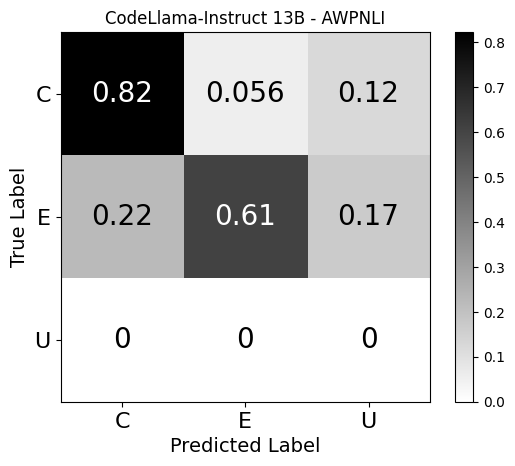

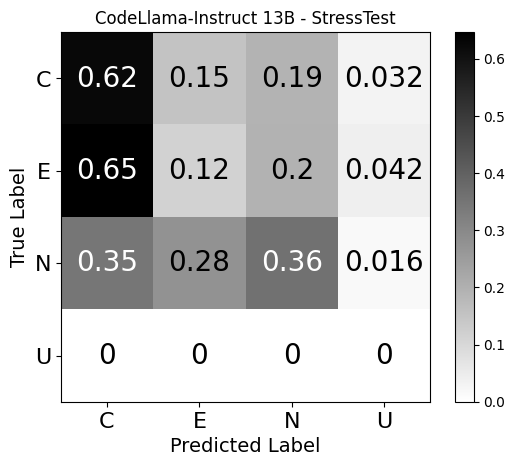

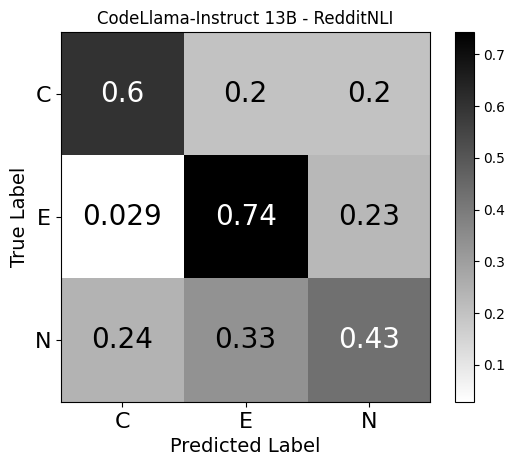

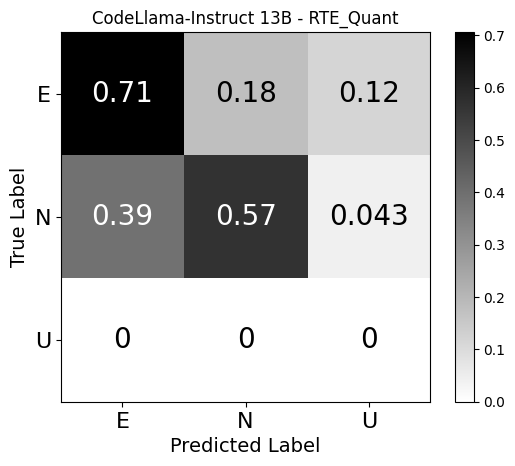

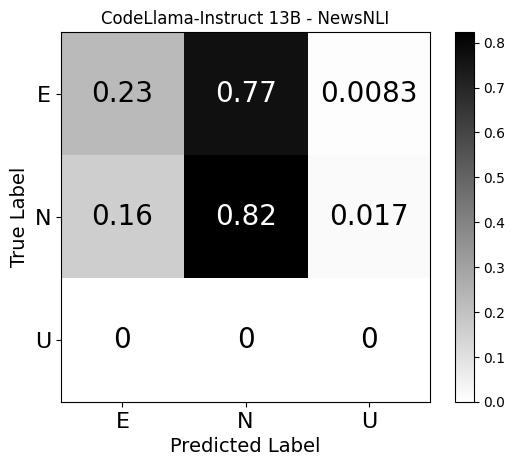

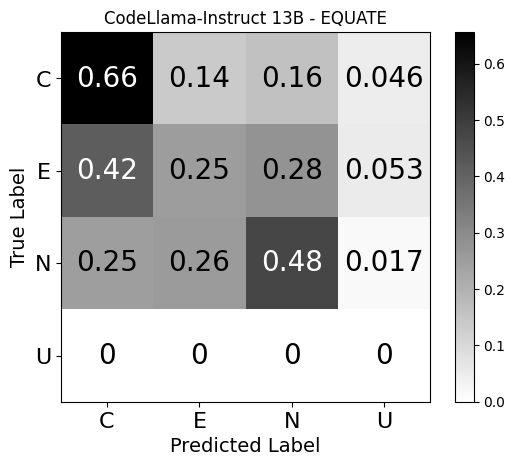

In [275]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

os.makedirs(os.path.join(results_path, "evaluation_new", "cf"), exist_ok=True)

# Define custom colormap from white to black
cmap_colors = [(1, 1, 1), (0, 0, 0)]  # White to Black
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)

for dataset in ["awpnli", "stresstest", "redditnli", "rtequant", "newsnli",]:
    filtered_df = qnli_results_df[qnli_results_df["source"] == dataset]
    if dataset in ["rtequant", "newsnli"]:
        labels = ["entailment", "neutral"]
    elif dataset == "awpnli":
        labels = ["contradiction", "entailment"]
    else:
        labels = ["contradiction", "entailment", "neutral"]
    if "unknown" in filtered_df["inferred_label"].unique():
        labels.append("unknown")
    cf = confusion_matrix(filtered_df["golden_label"], filtered_df["inferred_label"], labels=labels, normalize="true")
    display = ConfusionMatrixDisplay(cf, display_labels=[label[0].upper() for label in labels])
    # Increase label size within the squares
    display.plot(cmap=custom_cmap)
    # Increase font size of the numbers within the squares
    for text in display.text_.ravel():
        text.set_fontsize(20)  # Adjust font size as needed
    # Increase font size of the axis labels
    plt.xlabel('Predicted Label', fontsize=14)  # X-axis label
    plt.ylabel('True Label', fontsize=14)       # Y-axis label
    # Increase label size within the squares
    plt.gca().tick_params(axis='both', which='major', labelsize=16)
    plt.title(f"{model_display_name} - {dataset_name_mapping[dataset]}")
    plt.savefig(os.path.join(results_path, "evaluation_new", "cf", f"{dataset}_confusion_matrix.pdf"))


labels = ["contradiction", "entailment", "neutral"]
if "unknown" in qnli_results_df["inferred_label"].unique():
    labels.append("unknown")
cf = confusion_matrix(qnli_results_df["golden_label"], qnli_results_df["inferred_label"], labels=labels, normalize="true")
display = ConfusionMatrixDisplay(cf, display_labels=[label[0].upper() for label in labels])
display.plot(cmap=custom_cmap)
# Increase font size of the numbers within the squares
for text in display.text_.ravel():
    text.set_fontsize(20)  # Adjust font size as needed
# Increase font size of the axis labels
plt.xlabel('Predicted Label', fontsize=14)  # X-axis label
plt.ylabel('True Label', fontsize=14)       # Y-axis label
# Increase label size within the squares
plt.gca().tick_params(axis='both', which='major', labelsize=16)
plt.title(f"{model_display_name} - EQUATE")
plt.savefig(os.path.join(results_path, "evaluation_new", "cf", f"EQUATE_confusion_matrix.pdf"))

## BASELINE SCORES

In [276]:
# import numpy as np
# from numpy.random import Generator, BitGenerator
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
#
# ## Get the baseline micro metrics for the sub-datasets and for EQUATE
#
# scores_map = {ds_name: {"accuracy": [], "F1-E": [], "F1-N": [], "F1-C": [], "weighted-F1": []} for ds_name in dataset_name_mapping.keys()}
#
# for i in range(2):
#     for dataset in list(qnli_results_df["source"].unique()):
#         mask_source = qnli_results_df["source"] == dataset
#         nan_indices_len = qnli_results_df.loc[mask_source].shape[0]
#         label_counts = qnli_results_df[qnli_results_df["source"]==dataset]["golden_label"].value_counts(normalize=True)
#         bit_generator = np.random.PCG64(i)
#         generator = np.random.Generator(bit_generator)
#         imputed_labels = generator.choice(label_counts.index, size=nan_indices_len, p=label_counts.values)
#         # Assign the sampled indices to the corresponding positions
#         qnli_results_df.loc[mask_source, "random_label"] = imputed_labels
#         filtered_df = qnli_results_df[mask_source]
#         true_y, pred_y = filtered_df["golden_label"], filtered_df["inferred_label"]
#         scores_map[dataset]["accuracy"].append(accuracy_score(true_y, pred_y))
#         scores_map[dataset]["weighted-F1"].append(f1_score(true_y, pred_y, average="weighted"))
#         if dataset in ["rtequant", "newsnli"]:
#             labels = ["entailment", "neutral"]
#         elif dataset == "awpnli":
#             labels = ["contradiction", "entailment"]
#         else:
#             labels = ["contradiction", "entailment", "neutral"]
#         _, _, clsf_f1_scores, _ = precision_recall_fscore_support(true_y, pred_y)
#         for label, f1 in zip (labels, clsf_f1_scores):
#             scores_map[dataset][f"F1-{label[0].upper()}"].append(f1)
#     true_y, pred_y = qnli_results_df["golden_label"], qnli_results_df["inferred_label"]
#     scores_map["equate"]["accuracy"].append(accuracy_score(true_y, pred_y))
#     scores_map["equate"]["weighted-F1"].append(f1_score(true_y, pred_y, average="weighted"))
#     labels = ["contradiction", "entailment", "neutral"]
#     _, _, clsf_f1_scores, _ = precision_recall_fscore_support(true_y, pred_y)
#     for label, f1 in zip (labels, clsf_f1_scores):
#         scores_map["equate"][f"F1-{label[0].upper()}"].append(f1)
#
# scores_map

In [277]:
# for dataset, metrics in scores_map.items():
#     print(f"###############{dataset}##############")
#     for metric, scores_list in metrics.items():
#         print(f"{metric}: {round(np.mean(scores_list), 4)}")

In [278]:
# from sklearn.metrics import f1_score
# import numpy as np
#
# # Example true labels and predicted labels
# true_labels = qnli_results_df["golden_label"]  # True class labels
# predicted_labels = qnli_results_df["inferred_label"]  # Predicted class labels
#
# # Example class frequencies (number of samples for each class)
# print(qnli_results_df["golden_label"].value_counts(normalize=True))
# class_frequencies = qnli_results_df["golden_label"].value_counts().values  # List containing the number of samples for each class
#
# # Compute F1 score for each class
# f1_scores = []
# for class_id in range(len(class_frequencies)):
#     mask = np.array(true_labels) == class_id
#     f1_scores.append(f1_score(np.array(true_labels)[mask], np.array(predicted_labels)[mask]))
#
# # Calculate weighted F1 score
# weighted_f1_score = np.sum(np.array(f1_scores) * np.array(class_frequencies)) / np.sum(class_frequencies)
#
# print("Weighted F1 Score:", weighted_f1_score)